<a href="https://colab.research.google.com/github/shranith/DeepLearningwithPytorch/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.4 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
     |████████████████████████████████| 376 kB 66.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e894c4aad8a27dd881c3b2661bacad0046241aaa1ee96e801d45a46054e42c5d
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=2228324723009c67fbc72e82647abb31f96b128cf88d923a0515e8b376f6f5ab
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (3/3), done.


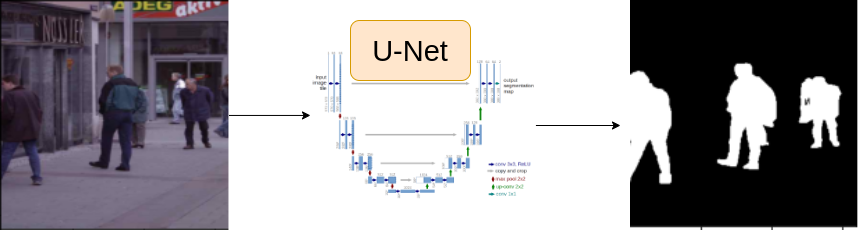

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE  = '/content/Human-Segmentation-Dataset-master/train.csv'

DATA_DIR = '/content'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 16
IMG_SIZE = 320
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'



In [6]:
df = pd.read_csv(CSV_FILE)

In [7]:
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[6]

mask_path = row.masks
image_path = row.images

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

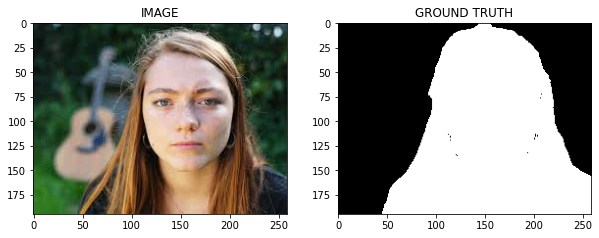

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

In [11]:
len(train_df), len(valid_df)

(232, 58)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p=0.5)
      ])
  

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [14]:
from torch.utils.data import Dataset

In [15]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask ,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.Tensor(mask)/255.0

    return image, mask



In [16]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [17]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


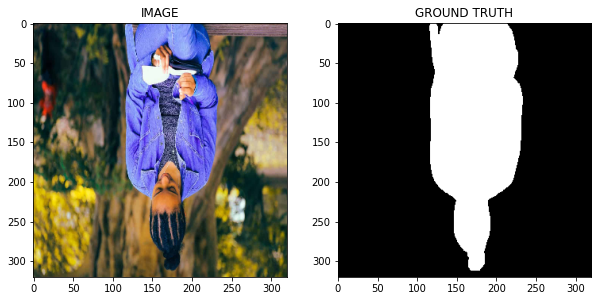

In [18]:
idx = 30

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [19]:
from torch.utils.data import DataLoader

In [20]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [35]:
print(len(trainloader))
print(len(valloader))

15
4


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name= ENCODER,
        encoder_weights= WEIGHTS,
        in_channels = 3,
        classes = 1, 
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)

      return logits, loss1 + loss2

    return logits


model = SegmentationModel()

model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [26]:
def train_fn(data_loader, model, optimizer):

  model.train()

  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(data_loader)


In [25]:
def eval_fn(data_loader, images):

  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss/len(data_loader)


# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)


In [28]:
best_valid_loss = np.inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(valloader, model)


  if valid_loss < best_valid_loss:

    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f" Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")
  

100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


SAVED MODEL
 Epoch : 1 Train_loss : 0.841984874010086 Valid_loss : 3.8603017330169678


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


SAVED MODEL
 Epoch : 2 Train_loss : 0.3470244248708089 Valid_loss : 0.3976423293352127


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


SAVED MODEL
 Epoch : 3 Train_loss : 0.32967390716075895 Valid_loss : 0.3597882464528084


100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


SAVED MODEL
 Epoch : 4 Train_loss : 0.25142655372619627 Valid_loss : 0.23428982123732567


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
 Epoch : 5 Train_loss : 0.21157563130060833 Valid_loss : 0.21734235435724258


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


 Epoch : 6 Train_loss : 0.2068206787109375 Valid_loss : 0.25140446051955223


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


 Epoch : 7 Train_loss : 0.19437332501014074 Valid_loss : 0.3299044035375118


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


 Epoch : 8 Train_loss : 0.22780049443244935 Valid_loss : 0.24372056126594543


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


SAVED MODEL
 Epoch : 9 Train_loss : 0.187945527335008 Valid_loss : 0.17953669279813766


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


 Epoch : 10 Train_loss : 0.1489387666185697 Valid_loss : 0.2072148248553276


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


SAVED MODEL
 Epoch : 11 Train_loss : 0.1466338336467743 Valid_loss : 0.17559684067964554


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


 Epoch : 12 Train_loss : 0.1653682331244151 Valid_loss : 0.2183970846235752


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


 Epoch : 13 Train_loss : 0.16828178813060124 Valid_loss : 0.21176616102457047


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


 Epoch : 14 Train_loss : 0.16559908042351404 Valid_loss : 0.20570133440196514


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


 Epoch : 15 Train_loss : 0.1336242084701856 Valid_loss : 0.24913211911916733


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


 Epoch : 16 Train_loss : 0.11584742814302444 Valid_loss : 0.19027983956038952


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED MODEL
 Epoch : 17 Train_loss : 0.10008141746123632 Valid_loss : 0.17418537475168705


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


 Epoch : 18 Train_loss : 0.2117082213362058 Valid_loss : 0.2809161990880966


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


 Epoch : 19 Train_loss : 0.1932912290096283 Valid_loss : 0.2752459906041622


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


 Epoch : 20 Train_loss : 0.16435660819212597 Valid_loss : 0.20434389635920525


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


 Epoch : 21 Train_loss : 0.14220711092154184 Valid_loss : 0.20176159776747227


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


 Epoch : 22 Train_loss : 0.12190247426430384 Valid_loss : 0.1834115870296955


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


SAVED MODEL
 Epoch : 23 Train_loss : 0.11123517354329428 Valid_loss : 0.1653914861381054


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


 Epoch : 24 Train_loss : 0.11580304006735484 Valid_loss : 0.17472895979881287


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

 Epoch : 25 Train_loss : 0.10675037254889806 Valid_loss : 0.17703081294894218


# Task 9 : Inference

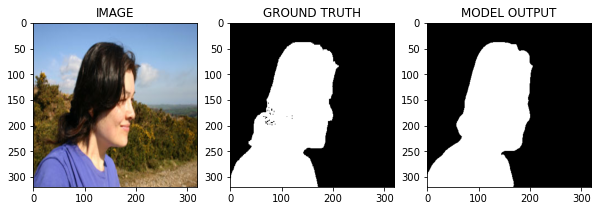

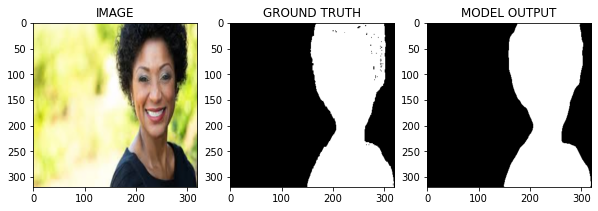

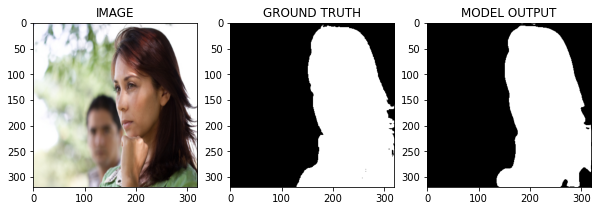

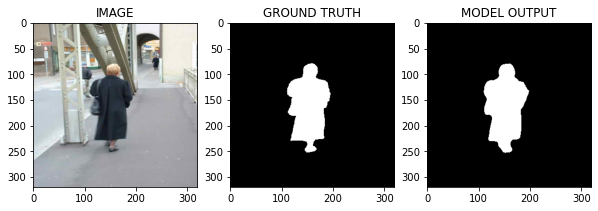

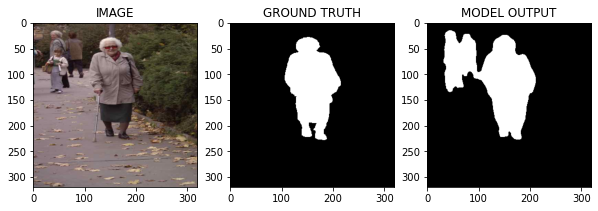

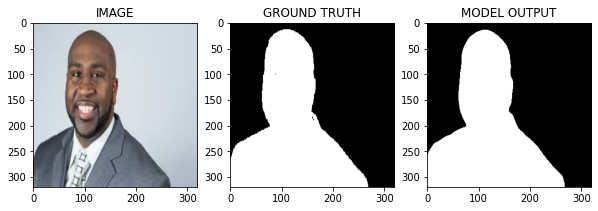

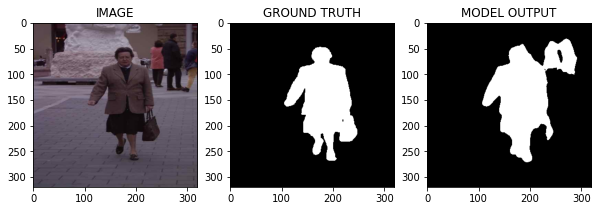

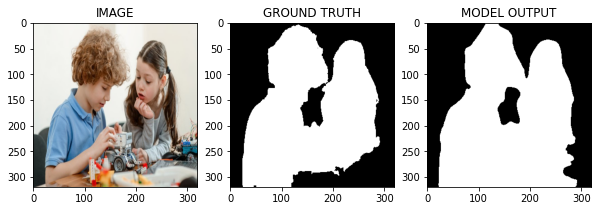

In [34]:
idx = 1


model.load_state_dict(torch.load('/content/best_model.pt'))


def infer(idx):
  image, mask = validset[idx]

  logits_mask = model(image.to(DEVICE).unsqueeze(0))
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > 0.5)*1.0

  helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))


indexes = [1,2,3,4,5,6,7,8]

for index in indexes:
  infer(index)

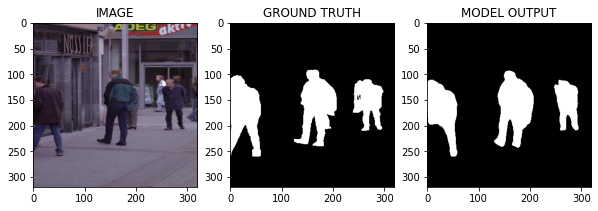

In [32]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))